# Differentially Private Point Patterns with GANs

## Setup

Install / load required dependencies

In [ ]:
from IPython.display import clear_output
import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import cuda, FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader

import datetime
import sys
import requests
import io
import os
import random
from time import sleep

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

Connect Google Drive to save models (only needed if models should be saved)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Use CUDA if GPU is available

In [ ]:
# Use GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### GeoPointGAN - Code Base

In [ ]:
###
# Large Spatial Transformer Network (STN) module
# 
# Input:
#   k = number of point dimensions
###
class STNkd(nn.Module):
    def __init__(self, k=2):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 32, 1)
        self.conv2 = torch.nn.Conv1d(32, 64, 1)
        self.conv3 = torch.nn.Conv1d(64, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, 512, 1)
        self.conv5 = torch.nn.Conv1d(512, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)
        self.bn8 = nn.BatchNorm1d(128)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn6(self.fc1(x)))
        x = F.relu(self.bn7(self.fc2(x)))
        x = F.relu(self.bn8(self.fc3(x)))
        x = self.fc4(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)

        return x

###
# PointNet encoder
#
# Input:
#   code_nfts = number of point embedding dimensions
#   num_points = number of points 
#   n_dim = number of point dimensions
#   global_feat = if True, return global feature embedding, if False, return individual (per-point) embeddings
#   trans = if True, use TransformNet implementation, if False, use Vanilla PointNet
###
class PointNetfeat(nn.Module):
    """
        PointNet Module
    """
    def __init__(self, code_nfts=2048, num_points=2500, n_dim = 2, global_feat=True, trans=True):
        super(PointNetfeat, self).__init__()
        self.n_dim = n_dim
        self.stn = STNkd(k = n_dim)
        self.code_nfts = code_nfts
        self.conv1 = torch.nn.Conv1d(n_dim, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, code_nfts, 1)

        self.bn1 = torch.nn.BatchNorm1d(64)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.bn3 = torch.nn.BatchNorm1d(code_nfts)
        self.trans = trans

        self.num_points = num_points
        self.global_feat = global_feat

    def forward(self, x):
        if self.trans:
            trans = self.stn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans)
            x = x.transpose(2,1)
        x = F.relu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x,_ = torch.max(x, 2)
        x = x.view(-1, self.code_nfts)
        if self.trans:
            if self.global_feat:
                return x #, trans
            else:
                x = x.view(-1, self.code_nfts, 1).repeat(1, 1, self.num_points)
                return torch.cat([x, pointfeat], 1), trans
        else:
            return x

###
# PointNet Generator
#
# Input:
#   code_nfts = number of point embedding dimensions
#   n_dim = number of point_dimensions
#   global_feat = argument for PointNet: if True, return global feature embedding, if False, return individual (per-point) embeddings
#   trans = argument for PointNet: if True, use TransformNet implementation, if False, use Vanilla PointNet
###
class PointNet_Generator(nn.Module):
    """ 
        Generator with PointNet Encoder, MLP Decoder
    """
    def __init__(self, code_nfts=2048, n_dim=2, global_feat=True, trans=True):
        super(PointNet_Generator, self).__init__()
        self.code_nfts = code_nfts
        self.n_dim = n_dim
        self.encoder = nn.Sequential(
            PointNetfeat(code_nfts, 1, n_dim = n_dim, global_feat=global_feat, trans=trans),
            nn.Linear(code_nfts, code_nfts),
            nn.BatchNorm1d(code_nfts),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_nfts, code_nfts),
            nn.BatchNorm1d(code_nfts),
            nn.ReLU(),
            nn.Linear(code_nfts, code_nfts // 2),
            nn.BatchNorm1d(code_nfts // 2),
            nn.ReLU(),
            nn.Linear(code_nfts // 2, n_dim),
            nn.Tanh()
        )


    def forward(self, x):
        #Encoder
        code = self.encoder(x)
        #Decoder
        x = self.decoder(code)
        x = x.view(-1, self.n_dim, 1)
        return x, code

###
# PointNet Discriminator
#
# Input:
#   code_nfts = number of point embedding dimensions
#   n_dim = number of point dimensions
#   global_feat = argument for PointNet: if True, return global feature embedding, if False, return individual (per-point) embeddings
#   trans = argument for PointNet: if True, use TransformNet implementation, if False, use Vanilla PointNet
###
class PointNet_Discriminator(nn.Module):
    """ 
        PointNet Discriminator
    """
    def __init__(self, code_nfts=2048, n_dim = 2, global_feat=True, trans = False):
        super(PointNet_Discriminator, self).__init__()
        self.n_dim = n_dim
        self.code_nfts = code_nfts
        self.cls = nn.Sequential(
            PointNetfeat(code_nfts, 1, n_dim = n_dim, global_feat=global_feat, trans=trans),
            nn.Linear(code_nfts, code_nfts),
            nn.BatchNorm1d(code_nfts),
            nn.ReLU(),
            nn.Linear(code_nfts, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        #Point level classifier
        x = self.cls(x)
        return x

Utilities

In [ ]:
#Plotting
def get_sample_points(G, z, n_dim):
    """
      Generate 'size' data samples
      ___

      G = Generator (in G.eval() mode)
      z = Random noise tensor of shape (n, n_dim, 1)
    """
    z_gen,_ = G(z)
    z_gen = z_gen.permute(2,0,1)
    n = z_gen.shape[1]
    batch_size = z_gen.shape[0]
    y_hat = z_gen.reshape(n * batch_size, n_dim) 
    points = y_hat.cpu().data.numpy()
    return points

def norm(x):
  for i in range(x.shape[1]):
    x[:,i] = 2 * (x[:,i]-min(x[:,i]))/(max(x[:,i])-min(x[:,i])) - 1
  return x

def rand_point(x, num_points, draw_with_replacement=False):
  total_num_points = x.shape[0]
  n_dim = x.shape[1]
  if draw_with_replacement:
    idx = np.random.randint(low=0,high=total_num_points, size=num_points) # Draw with replacement
  else:
    idx = np.random.choice(total_num_points, num_points) # Draw without replacement
  sample = x[idx]
  return sample

## Download Data

In [ ]:
url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/porto-test.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
c.columns = ["x","y"]
c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
po = c

url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/nyc-test.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
c.columns = ["x","y"]
c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
ny = c

url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/beijing-test.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
c.columns = ["x","y"]
c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
be = c

url="https://archive.ics.uci.edu/ml/machine-learning-databases/00246/3D_spatial_network.txt"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
c.columns = ["id","x","y","z"]
c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
c["z"] = 2 * (c["z"]-min(c["z"]))/(max(c["z"])-min(c["z"])) - 1
road = c[["x","y","z"]]

## Generate Data 

Get real and fake point samples.

In [ ]:
dataset = "3d_road"
eps = -1

if dataset == "new_york":
  real = np.array(ny)
elif dataset == "porto":
  real = np.array(po)
elif dataset == "beijing":
  real = np.array(be)
elif dataset == "3d_road":
  real = np.array(road)

n_dim = real.shape[1]
num_points = 7500 #Number of points to generate!
n_draws = 10
z_test = torch.randn(num_points, n_dim, 1).to(DEVICE) 
G = torch.load('gdrive/My Drive/PNGAN/model/G_%s_eps%i.pkl.gz' % (dataset, eps) ) #Link to your generator!

d = torch.zeros([n_draws,num_points,n_dim])
for i in range(n_draws):
  with torch.no_grad():
    G.eval()
    z_test = torch.randn(num_points, n_dim, 1).to(DEVICE) 
    fake = get_sample_points(G, z_test, n_dim)
    d[i,:,:] = torch.tensor(norm(fake))

fake = d.reshape(num_points*n_draws, n_dim)
real = rand_point(real, num_points*n_draws)

KeyboardInterrupt: ignored

Plot points

In [ ]:
#Real points
plt.scatter(real[:,0],real[:,1],s=0.01,alpha=0.5)

NameError: ignored

In [ ]:
#Fake points
plt.scatter(fake[:,0],fake[:,1],s=0.01,alpha=0.5)

NameError: ignored

In [ ]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def emd(X, Y):
    d = cdist(X, Y)
    assignment = linear_sum_assignment(d)
    return d[assignment].sum() / min(len(X), len(Y))

In [ ]:
emd_score = emd(real, fake)

In [ ]:
emd_score

## Compute point cloud metrics

In [ ]:
!pip install chamferdist

  Created wheel for chamferdist: filename=chamferdist-1.0.0-cp36-cp36m-linux_x86_64.whl size=4128828 sha256=37dbf2b5f6ab1a95527b7f52f8eca2809a216e09481810011acec1191e0be9fc
  Stored in directory: /root/.cache/pip/wheels/39/8b/71/6eb6de869c9e2b673d2afb970d5a35377f32c3f95cd726a8e3
Successfully built chamferdist


In [ ]:
from chamferdist import ChamferDistance

min_var_est = 1e-8


# Consider linear time MMD with a linear kernel:
# K(f(x), f(y)) = f(x)^Tf(y)
# h(z_i, z_j) = k(x_i, x_j) + k(y_i, y_j) - k(x_i, y_j) - k(x_j, y_i)
#             = [f(x_i) - f(y_i)]^T[f(x_j) - f(y_j)]
#
# f_of_X: batch_size * k
# f_of_Y: batch_size * k
def linear_mmd2(f_of_X, f_of_Y):
    loss = 0.0
    delta = f_of_X - f_of_Y
    loss = torch.mean((delta[:-1] * delta[1:]).sum(1))
    return loss


# Consider linear time MMD with a polynomial kernel:
# K(f(x), f(y)) = (alpha*f(x)^Tf(y) + c)^d
# f_of_X: batch_size * k
# f_of_Y: batch_size * k
def poly_mmd2(f_of_X, f_of_Y, d=2, alpha=1.0, c=2.0):
    K_XX = (alpha * (f_of_X[:-1] * f_of_X[1:]).sum(1) + c)
    K_XX_mean = torch.mean(K_XX.pow(d))

    K_YY = (alpha * (f_of_Y[:-1] * f_of_Y[1:]).sum(1) + c)
    K_YY_mean = torch.mean(K_YY.pow(d))

    K_XY = (alpha * (f_of_X[:-1] * f_of_Y[1:]).sum(1) + c)
    K_XY_mean = torch.mean(K_XY.pow(d))

    K_YX = (alpha * (f_of_Y[:-1] * f_of_X[1:]).sum(1) + c)
    K_YX_mean = torch.mean(K_YX.pow(d))

    return K_XX_mean + K_YY_mean - K_XY_mean - K_YX_mean


def _mix_rbf_kernel(X, Y, sigma_list):
    assert(X.size(0) == Y.size(0))
    m = X.size(0)

    Z = torch.cat((X, Y), 0)
    ZZT = torch.mm(Z, Z.t())
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.t()

    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma**2)
        K += torch.exp(-gamma * exponent)

    return K[:m, :m], K[:m, m:], K[m:, m:], len(sigma_list)


def mix_rbf_mmd2(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    # return _mmd2(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)


def mix_rbf_mmd2_and_ratio(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    # return _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)


################################################################################
# Helper functions to compute variances based on kernel matrices
################################################################################


def _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    return mmd2


def _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    mmd2, var_est = _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=const_diagonal, biased=biased)
    loss = mmd2 / torch.sqrt(torch.clamp(var_est, min=min_var_est))
    return loss, mmd2, var_est


def _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
        sum_diag2_X = sum_diag2_Y = m * const_diagonal**2
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)
        sum_diag2_X = diag_X.dot(diag_X)
        sum_diag2_Y = diag_Y.dot(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e
    K_XY_sums_1 = K_XY.sum(dim=1)                     # K_{XY} * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    Kt_XX_2_sum = (K_XX ** 2).sum() - sum_diag2_X      # \| \tilde{K}_XX \|_F^2
    Kt_YY_2_sum = (K_YY ** 2).sum() - sum_diag2_Y      # \| \tilde{K}_YY \|_F^2
    K_XY_2_sum  = (K_XY ** 2).sum()                    # \| K_{XY} \|_F^2

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    var_est = (
        2.0 / (m**2 * (m - 1.0)**2) * (2 * Kt_XX_sums.dot(Kt_XX_sums) - Kt_XX_2_sum + 2 * Kt_YY_sums.dot(Kt_YY_sums) - Kt_YY_2_sum)
        - (4.0*m - 6.0) / (m**3 * (m - 1.0)**3) * (Kt_XX_sum**2 + Kt_YY_sum**2)
        + 4.0*(m - 2.0) / (m**3 * (m - 1.0)**2) * (K_XY_sums_1.dot(K_XY_sums_1) + K_XY_sums_0.dot(K_XY_sums_0))
        - 4.0*(m - 3.0) / (m**3 * (m - 1.0)**2) * (K_XY_2_sum) - (8 * m - 12) / (m**5 * (m - 1)) * K_XY_sum**2
        + 8.0 / (m**3 * (m - 1.0)) * (
            1.0 / m * (Kt_XX_sum + Kt_YY_sum) * K_XY_sum
            - Kt_XX_sums.dot(K_XY_sums_1)
            - Kt_YY_sums.dot(K_XY_sums_0))
        )
    return mmd2, var_est

Dataset: new_york - Epsilon: 0 - Chamfer Dist: 3.598459 - MMD: -1.000000 - EMD: -1.000000
Dataset: new_york - Epsilon: 1 - Chamfer Dist: 1.279490 - MMD: -1.000000 - EMD: -1.000000
Dataset: new_york - Epsilon: 2 - Chamfer Dist: 1.314133 - MMD: -1.000000 - EMD: -1.000000
Dataset: new_york - Epsilon: -1 - Chamfer Dist: 1.281086 - MMD: -1.000000 - EMD: -1.000000
Dataset: porto - Epsilon: 0 - Chamfer Dist: 4.098497 - MMD: -1.000000 - EMD: -1.000000
Dataset: porto - Epsilon: 1 - Chamfer Dist: 3.095453 - MMD: -1.000000 - EMD: -1.000000
Dataset: porto - Epsilon: 2 - Chamfer Dist: 2.888405 - MMD: -1.000000 - EMD: -1.000000
Dataset: porto - Epsilon: -1 - Chamfer Dist: 2.485343 - MMD: -1.000000 - EMD: -1.000000
Dataset: beijing - Epsilon: 0 - Chamfer Dist: 4.260358 - MMD: -1.000000 - EMD: -1.000000
Dataset: beijing - Epsilon: 1 - Chamfer Dist: 3.548424 - MMD: -1.000000 - EMD: -1.000000
Dataset: beijing - Epsilon: 2 - Chamfer Dist: 2.527658 - MMD: -1.000000 - EMD: -1.000000
Dataset: beijing - Epsi

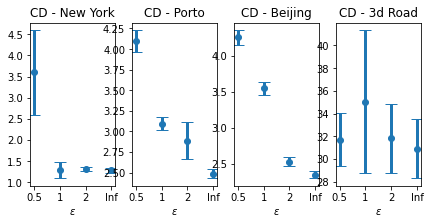

In [ ]:
##
datasets = ["new_york", "porto", "beijing","3d_road"]
epsilons = ["0","1","2","-1"]
num_points = 7500 #Number of points to generate at each draw
n_draws = 1 #Number of draws from generator
perms = 60
get_mmd = False
get_cd = True
get_emd = False
plotting = True
##

base = 1.0 #MMD settings
sigma_list = [1, 2, 4, 8, 16]
sigma_list = [sigma / base for sigma in sigma_list]
chamferDist = ChamferDistance() #Define CD

with torch.no_grad():
  if plotting==True:
    fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4, figsize=(7, 3))
  for dataset in datasets:
    cd_means = []
    mmd_means = []
    emd_means = []
    cd_sds = []
    mmd_sds = []
    emd_sds = []

    for eps in epsilons:
      cds = []
      mmds = []
      emds = []
      if dataset == "new_york":
        data = np.array(ny)
      elif dataset == "porto":
        data = np.array(po)
      elif dataset == "beijing":
        data = np.array(be)
      elif dataset == "3d_road":
        data = np.array(road)

      #z_test = torch.randn(num_points, n_dim, 1).to(DEVICE) 
      n_dim = data.shape[1]
      G = torch.load('gdrive/My Drive/PNGAN/model/G_%s_eps%s.pkl.gz' % (dataset, eps)) #Link to your generator!
      G.eval()

      for j in range(perms):
        d = torch.zeros([n_draws,num_points,n_dim])
        for i in range(n_draws):
          z_test = torch.randn(num_points, n_dim, 1).to(DEVICE) 
          fake = get_sample_points(G, z_test, n_dim)
          d[i,:,:] = torch.as_tensor(norm(fake))

        fake = torch.as_tensor(d.reshape(num_points*n_draws, n_dim))
        real = torch.as_tensor(rand_point(data, num_points*n_draws))

        if get_cd==True:
          cd = chamferDist(real.reshape(1, num_points*n_draws, n_dim).float(), fake.reshape(1, num_points*n_draws, n_dim).float(), bidirectional=True)
          cds.append(cd)
        if get_mmd==True:      
          mmd = mix_rbf_mmd2(real.float(), fake.float(), sigma_list=sigma_list)
          mmds.append(mmd)
        if get_emd==True:
          em = emd(real, fake)
          emds.append(em)
      
      if get_cd==True:
        cd_mean = torch.tensor(cds).mean()
        cd_sd = torch.tensor(cds).std()
      else:
        cd_mean = -1
        cd_sd = -1

      if get_mmd==True:
        mmd_mean = torch.tensor(mmds).mean()
        mmd_sd = torch.tensor(mmds).std()
      else:
        mmd_mean = -1
        mmd_sd = -1

      if get_emd==True:
        emd_mean = torch.tensor(emds).mean()
        emd_sd = torch.tensor(emds).std()
      else:
        emd_mean = -1
        emd_sd = -1

      print('Dataset: %s - Epsilon: %s - Chamfer Dist: %.6f - MMD: %.6f - EMD: %.6f' % (dataset, eps, cd_mean, mmd_mean, emd_mean))

      if get_cd==True:
        cd_means.append(cd_mean)
        cd_sds.append(cd_sd)
      if get_mmd==True:
        mmd_means.append(mmd_mean)
        mmd_sds.append(mmd_sd)
      if get_emd==True:
        emd_means.append(emd_mean)
        emd_sds.append(emd_sd)
    
    if plotting==True:
      if dataset=="new_york":
        # construct some data like what you have:
        means = cd_means
        std = cd_sds
        # create stacked errorbars:
        ax1.errorbar(["0.5","1","2","Inf"], means, std, fmt='o', lw=3, capsize=6)
        ax1.set_xlabel(r'$\epsilon$')
        ax1.set_title("CD - New York")
      elif dataset=="porto":
        # construct some data like what you have:
        means = cd_means
        std = cd_sds
        # create stacked errorbars:
        ax2.errorbar(["0.5","1","2","Inf"], means, std, fmt='o', lw=3, capsize=6)
        ax2.set_xlabel(r'$\epsilon$')
        ax2.set_title("CD - Porto")
      elif dataset=="beijing":
        # construct some data like what you have:
        means = cd_means
        std = cd_sds
        # create stacked errorbars:
        ax3.errorbar(["0.5","1","2","Inf"], means, std, fmt='o', lw=3, capsize=6)
        ax3.set_xlabel(r'$\epsilon$')
        ax3.set_title("CD - Beijing")
      elif dataset=="3d_road":
        # construct some data like what you have:
        means = cd_means
        std = cd_sds
        # create stacked errorbars:
        #plt.errorbar(np.arange(4), means, std, fmt='ok', lw=3)
        ax4.errorbar(["0.5","1","2","Inf"], means, std, fmt='o', lw=3, capsize=6)
        ax4.set_xlabel(r'$\epsilon$')
        ax4.set_title("CD - 3d Road")

In [ ]:
fig.tight_layout()
fig.savefig("test.png", bbox_inches = 'tight')

Print the results

Text(0.5, 1.0, 'CD - 3d Road')

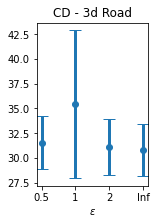

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# construct some data like what you have:
means = cd_means
std = cd_sds

# create stacked errorbars:
#plt.errorbar(np.arange(4), means, std, fmt='ok', lw=3)
fig, ax = plt.subplots(figsize=(2, 3))
ax.errorbar(["0.5","1","2","Inf"], means, std, fmt='o', lw=3, capsize=6)
ax.set_xlabel(r'$\epsilon$')
ax.set_title("CD - 3d Road")
#plt.xlim(-1, 8)

In [ ]:
fig.savefig("cd_3d_road.png", bbox_inches = 'tight')

In [ ]:
import matplotlib.image as mpimg

img_ny = mpimg.imread("cd_new_york.png")
img_po= mpimg.imread("cd_porto.png")
img_be= mpimg.imread("cd_beijing.png")
img_3d= mpimg.imread("cd_3d_road.png")

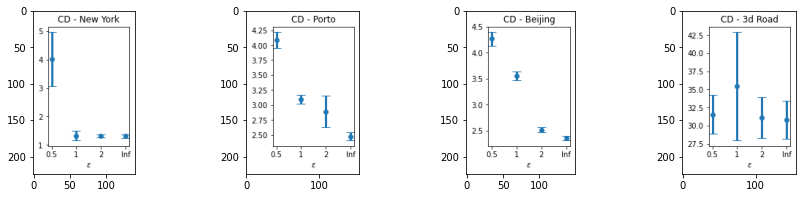

In [ ]:
fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4, figsize=(15, 3))
ax1.imshow(img_ny)
ax2.imshow(img_po)
ax3.imshow(img_be)
ax4.imshow(img_3d)